## Regression Problem - NYC Taxi Fare Prediction

In [1]:
#!pip install googlemaps

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
#import googlemaps
import random
from math import cos, asin, sqrt
import numpy as np
import datetime
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#Inorder to calculate the distance we have used the gogale map API as only coordinated are given
#tried to use this api to calculate distance but the dataset is quite large and only 10000 rows are processed at a time
#so dropped this technique to calculate distance
#gmaps = googlemaps.Client(key='***') 
#TYPE = "

In [58]:
data = pd.read_csv('C:\\Users\\mudit\\Downloads\\taxi\\data.csv', nrows=50000)

In [59]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [60]:
print('Sum of NaN values for each column')
print(data.isnull().sum())

Sum of NaN values for each column
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [61]:

data.describe() #take a look at the data
data.isnull().sum() #check for the null values
print("Minimum fare = " , data["fare_amount"].min())
print("Maximum fare = " , data["fare_amount"].max())
print("Negative fare rows = " , sum(data["fare_amount"] < 0))
print("0 fare rows = " , sum(data["fare_amount"] == 0))

Minimum fare =  -5.0
Maximum fare =  200.0
Negative fare rows =  6
0 fare rows =  3


In [62]:
#Data Cleaning

# Currently, minimum taxi fare in NYC is $2.5. Since, we have data from 2009, assuming that minimum fare 
# would be atleast $1, removing rows with fare < $1.5
print("Rows with fare<1 are ", sum(data["fare_amount"] < 1.5)) #Number of rows with fare < $1.5
print("Rows with fare>450 are ", sum(data["fare_amount"] > 450)) #Number of rows with fare > $450

#Maximum fare between two farthest points in NY city is $320 as per the current uber fare. 
#So considering all the data with fare>$450 and fare<1.5 as bad data, we will remove those values
data = data[(data["fare_amount"] > 1.5) & (data["fare_amount"] <= 450)]

Rows with fare<1 are  10
Rows with fare>450 are  0


In [63]:
#Data Cleaning

#NY City latitude is between 40.4965, 40.9159 and longitude is between -74.25 , -73.7016
#Identify latitudes and lngitudes which does not belong to NY City, adding some grace distance

# print(train[(train["pickup_latitude"] <39.8) | (train["pickup_latitude"] > 41.3)].shape[0])
# print(train[(train["pickup_longitude"] < -75) | (train["pickup_longitude"] > -71.8)].shape[0])
# print(train[(train["dropoff_latitude"] <39.8) | (train["dropoff_latitude"] > 41.3)].shape[0])
# print(train[(train["dropoff_longitude"] < -75) | (train["dropoff_longitude"] > -71.8)].shape[0])

#Remove rows with bad latitude and longitude values
data = data[(data["pickup_latitude"] >39.8) & (data["pickup_latitude"] < 41.3)]
data = data[(data["pickup_longitude"] > -75) & (data["pickup_longitude"] < -71.8)]
data = data[(data["dropoff_latitude"] >39.8) & (data["dropoff_latitude"] < 41.3)]
data = data[(data["dropoff_longitude"] > -75) & (data["dropoff_longitude"] < -71.8)]

#Removing 195532 rows with passenger count more than 6 and less than 1
# print(data[(data["passenger_count"] > 6 ) | (data["passenger_count"] < 1)].shape[0])

data = data[(data["passenger_count"] <= 6 ) & (data["passenger_count"] >= 1)]


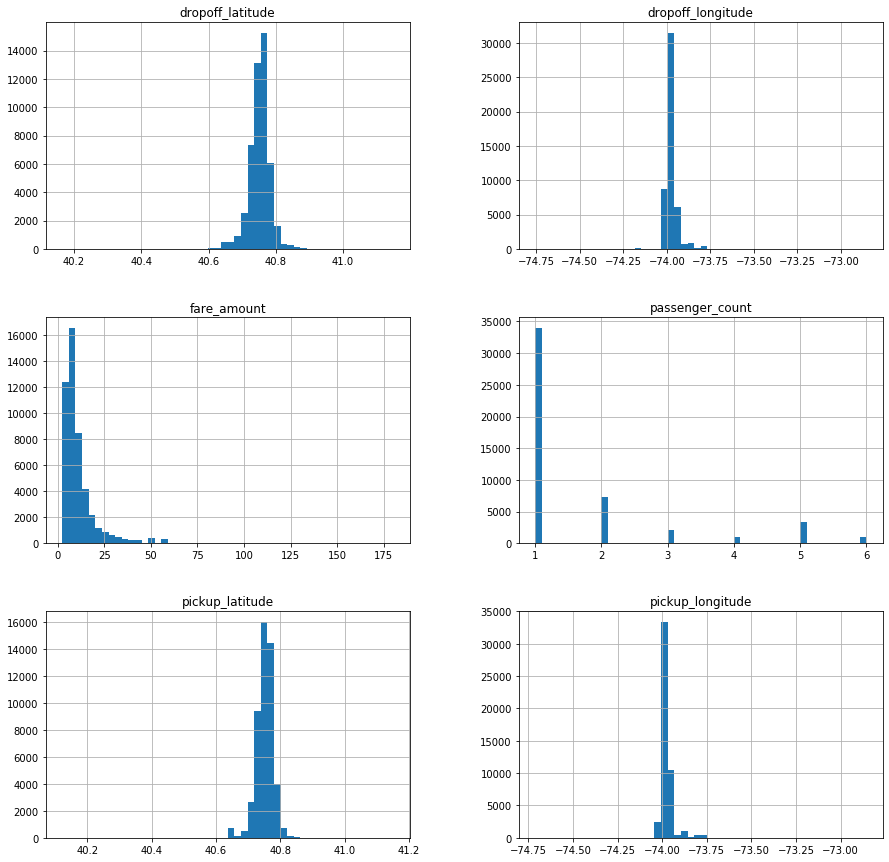

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50,figsize=(15,15)) #Look at the histograms
plt.show()

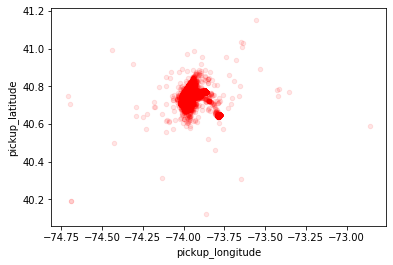

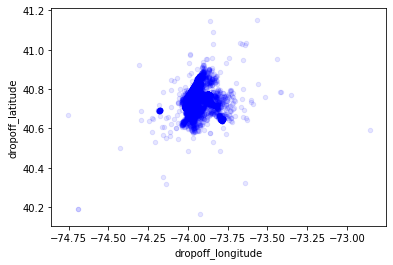

In [65]:
#Visualizing data
# train_sample = data.sample(n=100000) #take a sample of 100,000 randon rows
data.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude", c="red", alpha=0.1)
data.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude", c="blue", alpha=0.1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000242799735C8>,
      dtype=object)

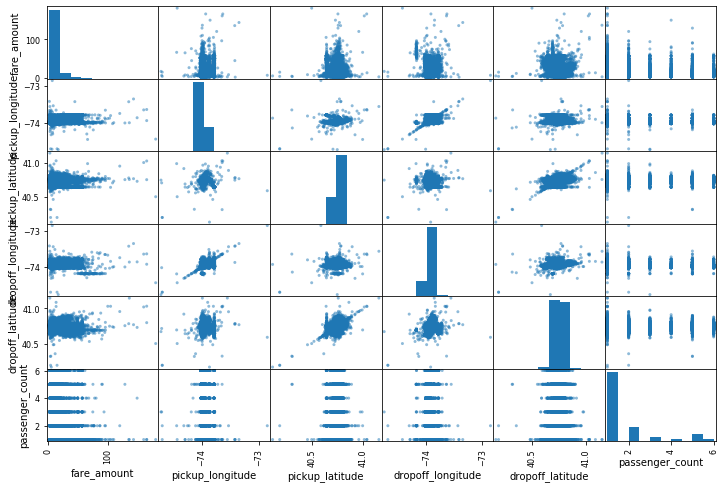

In [66]:
#Look for correlations anmong variables
corr = data.corr()
corr["fare_amount"].sort_values(ascending=False)
from pandas.plotting import scatter_matrix
scatter_matrix(data,figsize=(12,8))

In [67]:
# Define function to calculate distance between two points by latitude and longitude
# Faced some errors in this function as described below
# 1. lat1, lon1 etc were Panda series and so it won't allow its conversion to float.Typecasted to list when calling the function
# 2.Python won't allow operations between two list, so converted list to np.array
# 3.Math.cos,asin etc functions does not support np.array. So used np.cos, np.asin functions

def distance(lat1, lon1, lat2, lon2):
    lat1 = np.array(lat1)
    lon1 = np.array(lon1)
    lat2 = np.array(lat2)
    lon2 = np.array(lon2)
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return (7917.512 * np.arcsin(np.sqrt(a)))

# Assigning dummy value 1.1 to column "distance" to change its datatype to float64 from object
data["distance"] = 1.1

#Changing datatype of train.Distance from float64 to float16
data["distance"] = data["distance"].astype(np.float16)

#Calculating distance between pickup and drop points using Haversine formula
data['distance'] = distance(data.pickup_latitude.tolist(), data.pickup_longitude.tolist(),
                             data.dropoff_latitude.tolist(), data.dropoff_longitude.tolist())

In [68]:
data.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance'],
      dtype='object')

In [69]:
#checking null values after distance calculation
#as there maybe data with same pickup and dropoff coordinates
print('Train data: Sum of NaN values for each column')
print(data.isnull().sum())

Train data: Sum of NaN values for each column
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
distance             0
dtype: int64


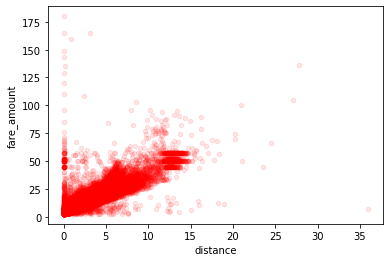

In [70]:
#Since we have distance now, let's see its relation with fare amount
# We can see a clear linear relationship between distance and fare. Also, there are some trips with zero
# distance by non-zero fare amount. We can also see some stright lines around fare 40-60, may be fixed fare
# to airports

data.plot(kind="scatter", x="distance", y="fare_amount", c="red", alpha=0.1)
plt.show()

In [71]:
# Create three new variables for storing year,time and hour of pickup
import datetime
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])
data["year"] = data["pickup_datetime"].dt.year
data["time"] = data["pickup_datetime"].dt.time
data["hour"] = data["pickup_datetime"].dt.hour

In [75]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,time,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,2009,17:26:21,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,2010,16:52:16,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,2011,00:35:00,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,2012,04:30:42,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,2010,07:51:00,7


In [76]:
# Define Function to polulate new column "weekday" where 1 = weekday, 0 = weekend
def weekday(pickup_date):
    weekday = []
    for index,val in pickup_date.iteritems():
        val = pd.to_datetime(val)
        if(val.weekday() == 5 or val.weekday() == 6):
            weekday.append(0)
        else:
            weekday.append(1)
    return weekday

data["weekday"] = 0
data["weekday"] = weekday(data["pickup_datetime"])

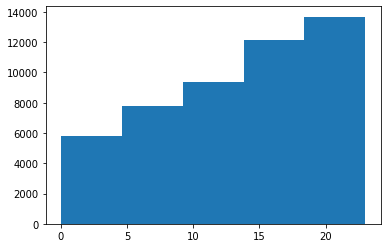

In [77]:
data["hour"] = data["pickup_datetime"].dt.hour
#Histogram on train.hour to see when highest number of cabs are booked
plt.hist(data["hour"], bins=5)
plt.show()

In [78]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,time,hour,weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,2009,17:26:21,17,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,2010,16:52:16,16,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,2011,00:35:00,0,1
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,2012,04:30:42,4,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,2010,07:51:00,7,1


In [79]:
# Let's categorize time data into morning, afternoon, evening and night in new column "part_of_day"

def time_in_range(start, end, x):
    # Return true if x is in the range [start, end]
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end
    
def assign_day_part(pickup_date):
    day_part = []
    # Morning = 0600-1000
    mornStart = datetime.time(6, 0, 1)
    mornEnd = datetime.time(10, 0, 0)

    # Midday = 1000-1600
    midStart = datetime.time(10, 0, 1)
    midEnd = datetime.time(16, 0, 0)

    # Evening = 1600-2000
    eveStart = datetime.time(16, 0, 1)
    eveEnd = datetime.time(20, 0, 0)
    
    # Night = 2000-0000
    nightStart = datetime.time(20, 0, 1)
    nightEnd = datetime.time(0, 0, 0)

    # Late Night = 0000-0600
    lateStart = datetime.time(0, 0, 1)
    lateEnd = datetime.time(6, 0, 0)
    
    for index,val in pickup_date.iteritems():
        if time_in_range(mornStart, mornEnd, val.time()):
            day_part.append("morning")
        elif time_in_range(midStart, midEnd, val.time()):
            day_part.append("midday")
        elif time_in_range(eveStart, eveEnd, val.time()):
            day_part.append("evening")
        elif time_in_range(nightStart, nightEnd, val.time()):
            day_part.append("night")
        elif time_in_range(lateStart, lateEnd, val.time()):
            day_part.append("lateNight")

    return day_part

data["part_of_day"] = assign_day_part(data["pickup_datetime"])

# We do not need time and hour variables now. So, dropping them
data = data.drop(["time", "hour"], axis=1)

In [80]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,weekday,part_of_day
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,2009,1,evening
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,2010,1,evening
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,2011,1,lateNight
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,2012,0,lateNight
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,2010,1,morning


C:\Users\mudit\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


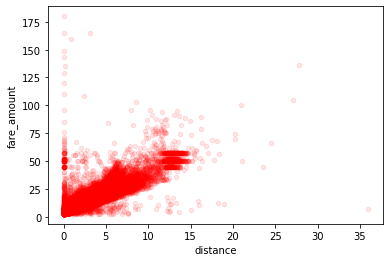

In [81]:
#Since we have distance and classification of weekday now, let's see the correlation

data.plot(kind="scatter", x="distance", y="fare_amount", c="red", alpha=0.1)


In [82]:
# REMOVE COMMENTS

# #Since we have distance and classification of weekday now, let's see the correlation
# # We see that distance is highly related to fare amount positively.

print(data.corr()["fare_amount"])


fare_amount          1.000000
pickup_longitude     0.407387
pickup_latitude     -0.196374
dropoff_longitude    0.318082
dropoff_latitude    -0.157991
passenger_count      0.015950
distance             0.851776
year                 0.121433
weekday              0.002030
Name: fare_amount, dtype: float64


In [83]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,weekday,part_of_day
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,2009,1,evening
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,2010,1,evening
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,2011,1,lateNight
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,2012,0,lateNight
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,2010,1,morning


In [84]:
# Convert categorical varibale "part_of_day" from to numerical value using sklearn LabelBinarizer
# This will create 5 new columns - evening, lateNight, midday, morning, night

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb_results = lb.fit_transform(data["part_of_day"])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

data = pd.merge(data, lb_results_df, left_index=True, right_index=True) #Merge output with training set

In [85]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,weekday,part_of_day,evening,lateNight,midday,morning,night
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,2009,1,evening,1,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,2010,1,evening,1,0,0,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,2011,1,lateNight,0,1,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,2012,0,lateNight,0,1,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,2010,1,morning,0,0,0,1,0


In [86]:
data.drop(["part_of_day"], axis=1, inplace=True) # Dropping part_of_day variable

In [95]:
# Let us also drop pickup_datetime variable as we have included variables like year and part_of_day
data.drop(["pickup_datetime"], axis=1, inplace=True)

In [96]:
data.drop(["key"], axis=1, inplace=True)

In [97]:
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,weekday,evening,lateNight,midday,morning,night
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,2009,1,1,0,0,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,2010,1,1,0,0,0,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,2011,1,0,1,0,0,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,2012,0,0,1,0,0,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,2010,1,0,0,0,1,0


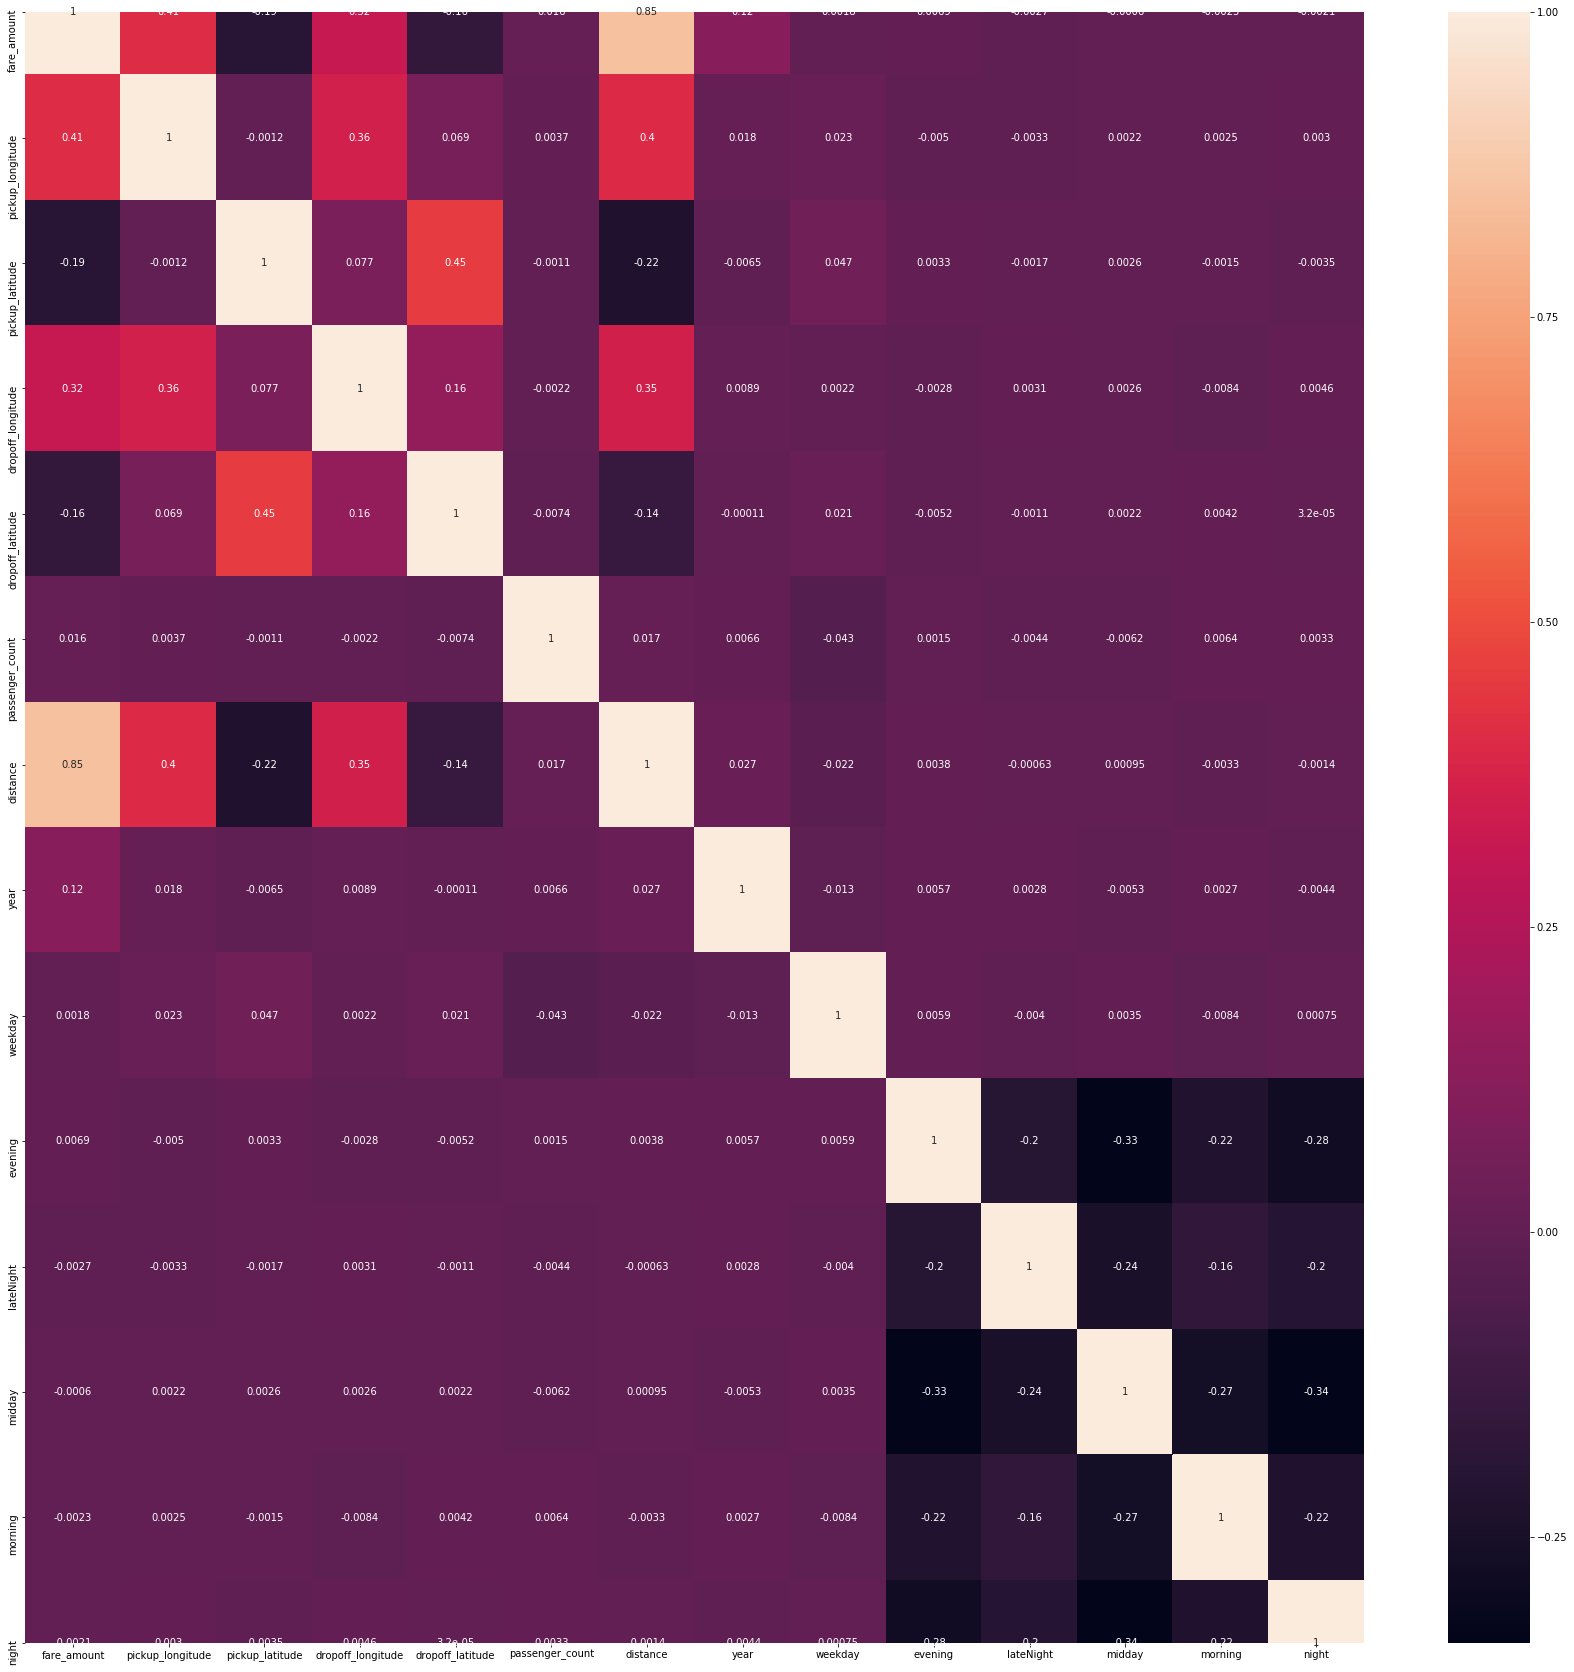

In [98]:
import seaborn as sn
# Let's check how the features correlate
colormap = plt.cm.RdBu
plt.figure(figsize=(30,30))
#plt.title('Pearson Correlation of Features', y=1.05, size=15)
sn.heatmap(data.corr(), annot=True)

In [104]:
#when distance is calculated no need for these variables
data.drop(["pickup_longitude"], axis=1, inplace=True)
data.drop(["pickup_latitude"], axis=1, inplace=True)
data.drop(["dropoff_longitude"], axis=1, inplace=True)
data.drop(["dropoff_latitude"], axis=1, inplace=True)

In [105]:
data.head()

,fare_amount,passenger_count,distance,year,weekday,evening,lateNight,midday,morning,night
0,4.5,1,0.640487,2009,1,1,0,0,0,0
1,16.9,1,5.250670,2010,1,1,0,0,0,0
2,5.7,2,0.863411,2011,1,0,1,0,0,0
3,7.7,1,1.739386,2012,0,0,1,0,0,0
4,5.3,1,1.242218,2010,1,0,0,0,1,0


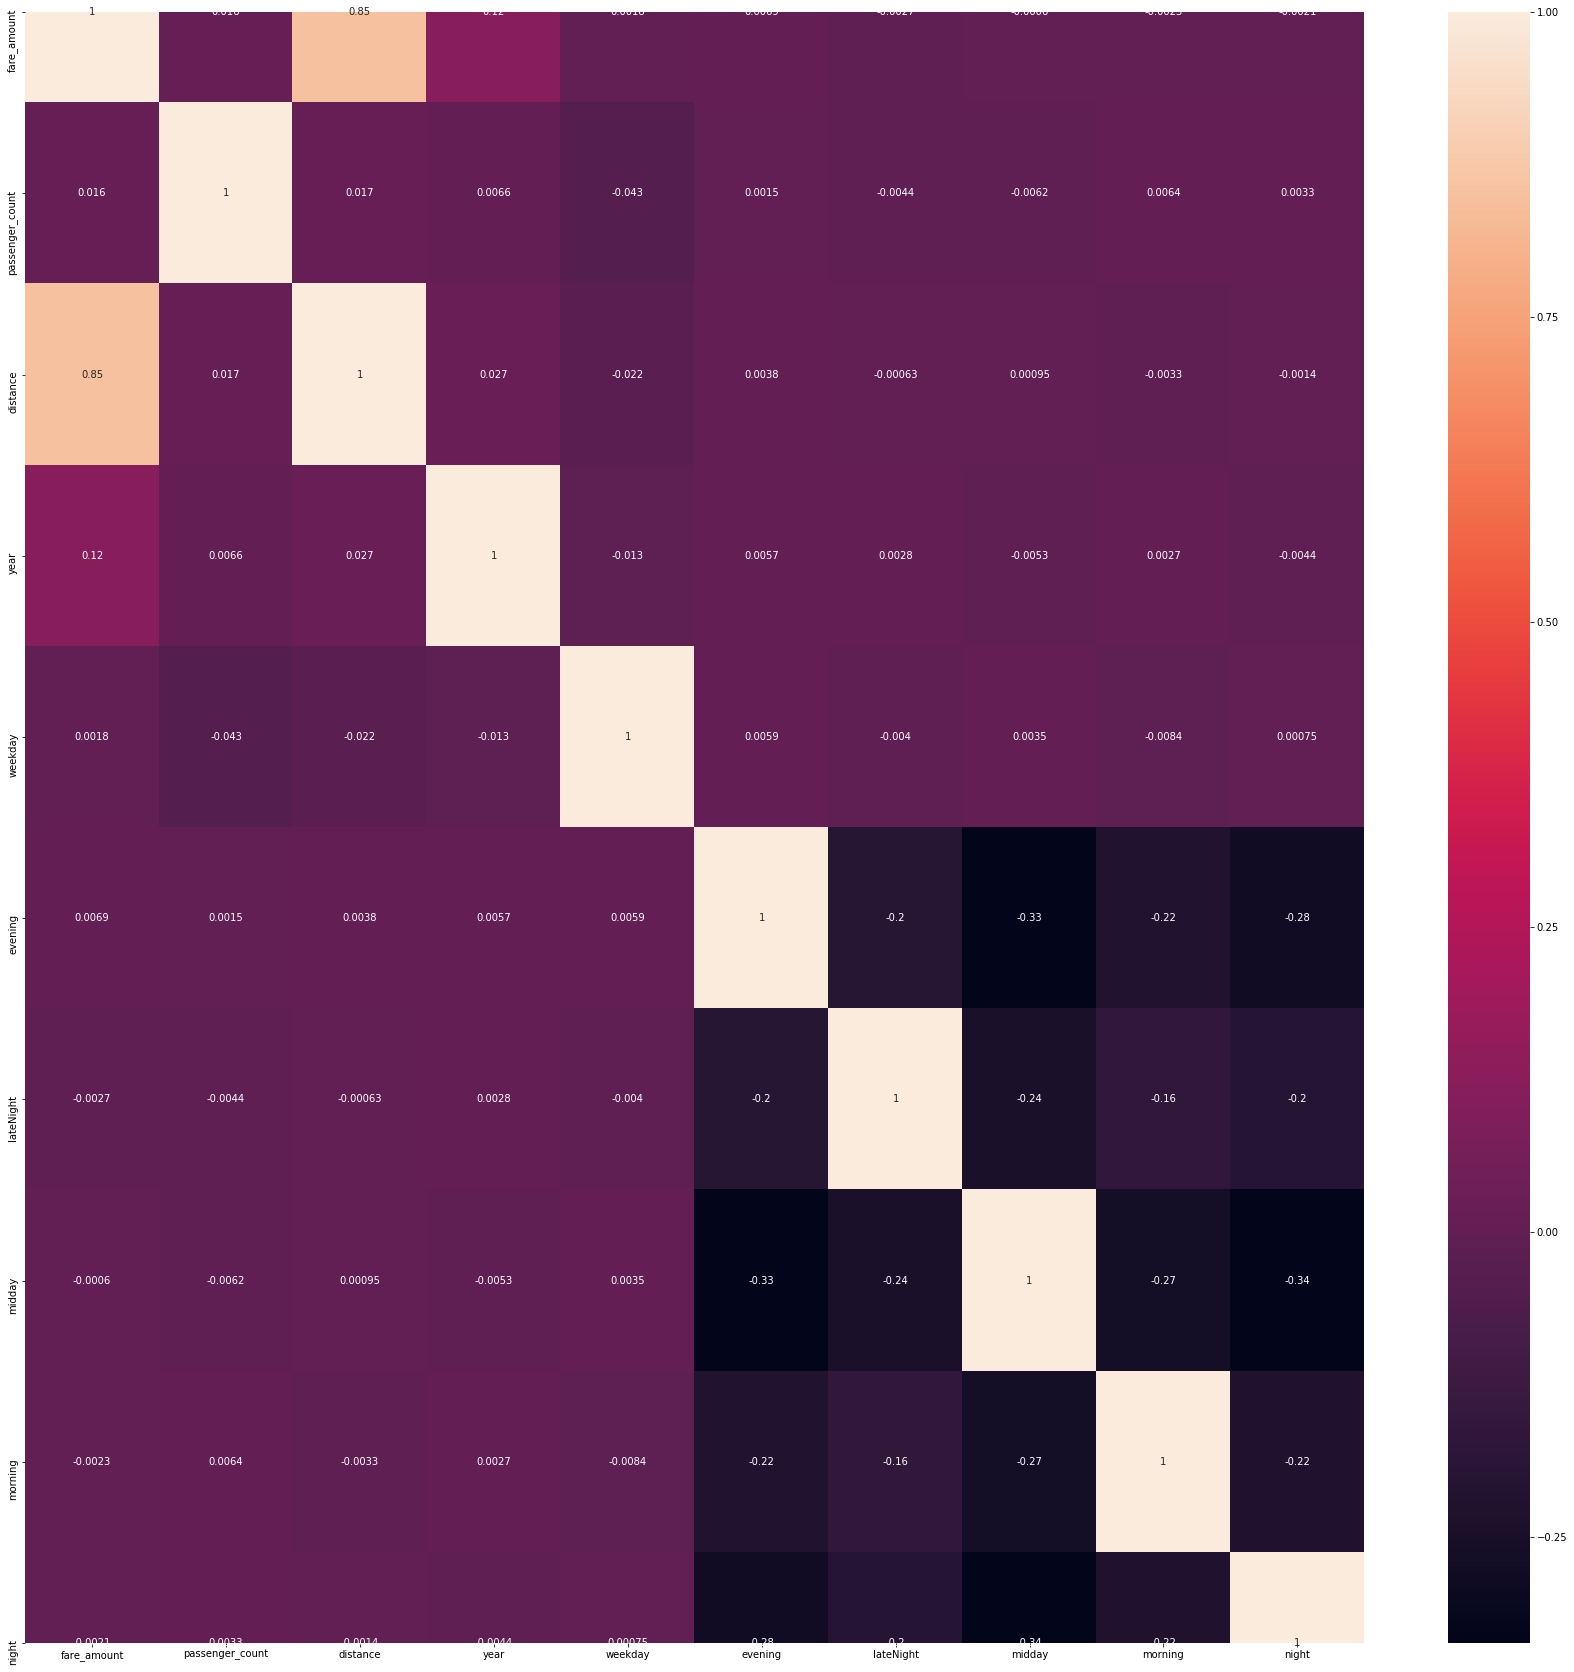

In [106]:
import seaborn as sn
# Let's check how the features correlate
colormap = plt.cm.RdBu
plt.figure(figsize=(30,30))
#plt.title('Pearson Correlation of Features', y=1.05, size=15)
sn.heatmap(data.corr(), annot=True)

#muticolinearity is removed

In [107]:
#creating temporary data
new_data=data

In [108]:
#Let us separate the response variable fare_amount 
train_labels = new_data["fare_amount"]
new_data.drop(["fare_amount"], axis=1, inplace=True)
new_data.head()

,passenger_count,distance,year,weekday,evening,lateNight,midday,morning,night
0,1,0.640487,2009,1,1,0,0,0,0
1,1,5.250670,2010,1,1,0,0,0,0
2,2,0.863411,2011,1,0,1,0,0,0
3,1,1.739386,2012,0,0,1,0,0,0
4,1,1.242218,2010,1,0,0,0,1,0


In [110]:
import statsmodels.api as sm

In [111]:
#assigning independent and reponse variable
X = sm.add_constant( new_data )
Y = train_labels

In [123]:
X_features = new_data.columns
X_features

Index(['passenger_count', 'distance', 'year', 'weekday', 'evening',
       'lateNight', 'midday', 'morning', 'night'],
      dtype='object')

In [224]:
#here we are splitting the dataset
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split( X ,Y,train_size = 0.8,random_state = 42 )

In [225]:
# Fitting the Model
taxi_model_1 = sm.OLS(train_y, train_X).fit()
taxi_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                 1.333e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        02:33:24   Log-Likelihood:            -1.1464e+05
No. Observations:               38035   AIC:                         2.293e+05
Df Residuals:                   38026   BIC:                         2.294e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -860.1242     22.761    -37.789      0.000    -904.737    -815.512
passenger_count     0.0170      0.020      0.867      0.386      -0.022       0.056
distance            3.6287      0.011    323.301      0.000       3.607       3.651
year                0.5148      0.014     37.917      0.000       0.488       0.541
weekday             0.4378      0.056      7.796      0.000       0.328       0.548
evening          -171.9702      4.553    -37.775      0.000    -180.893    -163.047
lateNight        -172.1050      4.553    -37.802      0.000    -181.029    -163.181
midday           -172.0257      4.552    -37.789      0.000    -180.948    -163.103
morning          -172.0276      4.553    -37.784      0.000    -180.951    -163.104
night            -171.9957      4.552    -37.783      0.000    -180.918    -163.073
==============================================================================
Omnibus:                    53607.776   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         57941288.891
Skew:                           7.830   Prob(JB):                         0.00
Kurtosis:                     193.566   Cond. No.                     1.23e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.02e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [131]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [132]:
# calculating Variance inflation factor 
def get_vif_factors( X ):
    X_matrix = X.as_matrix()
    vif = [ variance_inflation_factor( X_matrix, i ) for i in range( X_matrix.shape[1] ) ]
    vif_factors = pd.DataFrame()
    vif_factors['column'] = X.columns
    vif_factors['vif'] = vif
    return vif_factors

In [133]:
vif_factors = get_vif_factors( X[X_features] )
vif_factors

C:\Users\mudit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,column,vif
0,passenger_count,1.002258
1,distance,1.001475
2,year,1.000959
3,weekday,1.002589
4,evening,248946.937308
5,lateNight,148737.482923
6,midday,335710.805075
7,morning,174552.308958
8,night,253211.986805


In [134]:
# Select the features that have VIF value more than 4
columns_with_large_vif = vif_factors[vif_factors.vif > 4].column

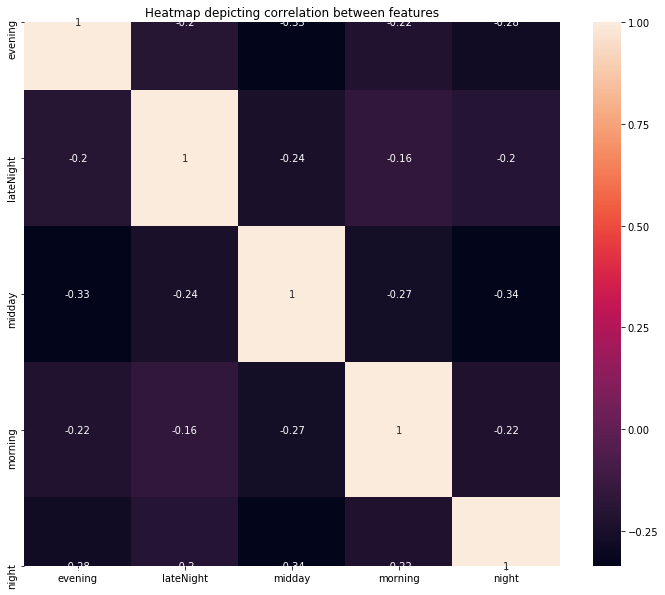

In [135]:
# Plot the heatmap for features with more than 4
plt.figure( figsize = (12,10) )
sn.heatmap( X[columns_with_large_vif].corr(), annot = True );
plt.title( "Heatmap depicting correlation between features");

In [138]:
columns_to_be_removed = ['midday','year']
X_new_features = list( set(X_features) - set(columns_to_be_removed) )
#midday show high negative muti-colinearity with other variables
#and after removing midday, variable year was showing high vif, so eliminated that as well

In [139]:
get_vif_factors( X[X_new_features] )

C:\Users\mudit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,column,vif
0,morning,1.312158
1,night,1.457568
2,weekday,2.402623
3,evening,1.453437
4,lateNight,1.264444
5,passenger_count,2.138244
6,distance,1.669424


In [142]:
# Building a new model after removing multicollinearity
train_X = train_X[['const']+X_new_features]
taxi_model_2 = sm.OLS(train_y, train_X).fit()
taxi_model_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.727      
Dependent Variable: fare_amount      AIC:                230702.2627
Date:               2020-02-24 01:05 BIC:                230770.6328
No. Observations:   38035            Log-Likelihood:     -1.1534e+05
Df Model:           7                F-statistic:        1.449e+04  
Df Residuals:       38027            Prob (F-statistic): 0.00       
R-squared:          0.727            Scale:              25.215     
---------------------------------------------------------------------
                  Coef.   Std.Err.     t      P>|t|    [0.025  0.975]
---------------------------------------------------------------------
const             3.4696    0.0762   45.5074  0.0000   3.3201  3.6190
morning           0.0203    0.0819    0.2473  0.8046  -0.1403  0.1808
night             0.0294    0.0731    0.4019  0.6878  -0.1138  0.1725
weekday           0.4183    0.0572    7.3118  0.0000   0.3061  0.5304
evening           0.0653    0.0734    0.8891  0.3739  -0.0786  0.2092
lateNight        -0.0655    0.0864   -0.7576  0.4487  -0.2348  0.1039
passenger_count   0.0190    0.0200    0.9468  0.3437  -0.0203  0.0582
distance          3.6392    0.0114  318.3742  0.0000   3.6168  3.6616
--------------------------------------------------------------------
Omnibus:            52209.399     Durbin-Watson:        1.998       
Prob(Omnibus):      0.000         Jarque-Bera (JB):     50820469.234
Skew:               7.450         Prob(JB):             0.000       
Kurtosis:           181.453       Condition No.:        17          
====================================================================

"""

In [163]:
#from the above model it is found that only distance and weekday variables are significant
#so we will create a new model with only these variables
significant_vars = ['distance', 'weekday']
train_X = train_X[significant_vars]

In [165]:
taxi_model_3 = sm.OLS(train_y, train_X).fit()
taxi_model_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
=================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.874      
Dependent Variable:     fare_amount      AIC:                         234680.2391
Date:                   2020-02-24 01:39 BIC:                         234697.3316
No. Observations:       38035            Log-Likelihood:              -1.1734e+05
Df Model:               2                F-statistic:                 1.314e+05  
Df Residuals:           38033            Prob (F-statistic):          0.00       
R-squared (uncentered): 0.874            Scale:                       27.999     
--------------------------------------------------------------------------------------
                Coef.       Std.Err.         t          P>|t|       [0.025      0.975]
--------------------------------------------------------------------------------------
distance        3.9757        0.0107      370.5074      0.0000      3.9547      3.9968
weekday         3.2476        0.0388       83.6730      0.0000      3.1716      3.3237
---------------------------------------------------------------------------------
Omnibus:                 47823.769         Durbin-Watson:            1.954       
Prob(Omnibus):           0.000             Jarque-Bera (JB):         39648970.749
Skew:                    6.279             Prob(JB):                 0.000       
Kurtosis:                160.673           Condition No.:            4           
=================================================================================

"""

<Figure size 576x432 with 0 Axes>

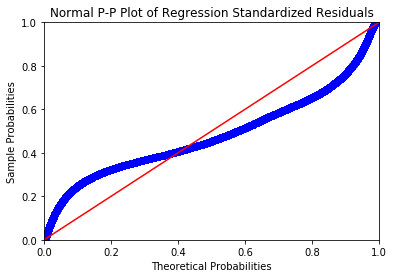

In [168]:
### Residual Analysis

# P-P Plot
def draw_pp_plot( model, title ):
    probplot = sm.ProbPlot( model.resid );
    plt.figure( figsize = (8, 6) );
    probplot.ppplot( line='45' );
    plt.title( title );
    plt.show();
    
draw_pp_plot( taxi_model_3,"Normal P-P Plot of Regression Standardized Residuals");

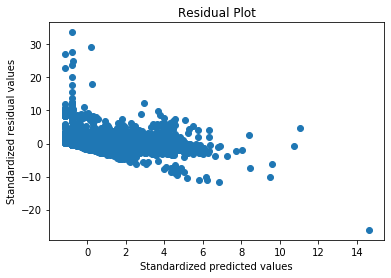

In [182]:
# Homoscedasticity
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

def plot_resid_fitted( fitted, resid, title):
    plt.scatter( get_standardized_values( fitted ),get_standardized_values( resid ) )
    plt.title( title )
    plt.xlabel( "Standardized predicted values")
    plt.ylabel( "Standardized residual values")
    plt.show()

plot_resid_fitted( taxi_model_3.fittedvalues,ipl_model_3.resid,"Residual Plot")

In [177]:
# Z-Score
from scipy.stats import zscore

In [186]:
check_data=data
check_data.head()

,passenger_count,distance,year,weekday,evening,lateNight,midday,morning,night,zscore_fare
0,1,0.640487,2009,1,1,0,0,0,0,-0.713322
1,1,5.250670,2010,1,1,0,0,0,0,0.576789
2,2,0.863411,2011,1,0,1,0,0,0,-0.588472
3,1,1.739386,2012,0,0,1,0,0,0,-0.380390
4,1,1.242218,2010,1,0,0,0,1,0,-0.630089


In [185]:
check_data["zscore_fare"] = zscore(train_labels )


In [187]:
check_data[ (check_data['zscore_fare'] > 3.0) | (check_data['zscore_fare'] < -3.0) ]

,passenger_count,distance,year,weekday,evening,lateNight,midday,morning,night,zscore_fare
35,1,7.942401,2015,0,0,0,1,0,0,4.852885
105,1,0.000000,2009,1,0,0,0,1,0,4.228637
132,2,12.336517,2009,1,1,0,0,0,0,3.975817
147,1,12.701453,2014,1,0,1,0,0,0,4.280658
204,2,11.175160,2011,1,0,0,0,1,0,3.240245
...,...,...,...,...,...,...,...,...,...,...
48550,1,8.940586,2015,1,0,0,0,0,1,4.180778
48554,2,13.767908,2011,1,0,1,0,0,0,3.500348
48638,5,12.251880,2011,1,0,0,1,0,0,3.999746
48649,2,13.709240,2015,1,0,0,0,0,1,4.783177


In [202]:
### Making predictions on validation set
pred_y = taxi_model_3.predict( test_X[train_X.columns] )

#Measuring RMSE
from sklearn import metrics
metrics.mean_squared_error(pred_y, test_y)

28.640172004823572

In [215]:
pred_y.head()#predicted values

18439     6.223242
35855     7.638086
41437    11.426949
13469     4.271266
10304     3.940767
dtype: float64

In [216]:
test_y.head()#actual values

18439     5.7
35855     5.7
41437    12.1
13469     6.5
10304     4.5
Name: fare_amount, dtype: float64

In [ ]:
#accuaracy of 87.4% is achieved and different transformations were applied but the best model
#achieved was model 3 only because when transformation were performed r-square value got decreased